In [65]:
import lzma
from math import sqrt
import pandas as pd
from geopy import Point, distance
import geojson
import matplotlib.pyplot as plt
import numpy as np
import pmdarima
from scipy import stats
from elasticsearch import Elasticsearch, helpers
import util
from pandarallel import pandarallel
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
es = Elasticsearch(
    hosts=["https://elastic.tccurbstads.com:443"],
    basic_auth=("elastic", "!@ContaElastic")
)

pandarallel.initialize(progress_bar=True, nb_workers=5)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:

def isPointInShape(row):
    response = es.search(index='test123456789', query={
        "bool": {
            "must": [{
                "match": {
                    "COD": row['COD_LINHA']
                }
            }],
            "filter": {
                "geo_distance": {
                    "distance": "300m",
                    "coordinate": {
                        "lat": row['LAT'], "lon": row['LON']
                    }
                }
            }
        }})

    if response['hits']['total']['value'] <= 0:
        return

    hits = [hit['_source'] for hit in response['hits']['hits']]
    if len(hits) <= 1:
        return

    df = pd.DataFrame(hits)

    df['distance'] = df.apply(lambda row1: distance.geodesic(
        (row1['coordinate']['coordinates'][1], row1['coordinate']['coordinates'][0]), (row['LAT'], row['LON'])).m, axis=1)

    df.sort_values(by=['distance'], inplace=True, ascending=True)

    df = df.groupby(['SHP']).head(2)

    df['closestDirection'] = df.apply(
        lambda row1: row1['direction'] - row['direction'], axis=1).abs().mean()

    df.sort_values(by=['closestDirection'], inplace=True, ascending=True)
    df = df[df['SHP'] == df['SHP'].iloc[0]]

    p3 = np.array([row['LAT'], row['LON']])

    if (len(df) <= 1):
        return

    p1 = np.array([df['coordinate'].iloc[0]['coordinates']
                   [1], df['coordinate'].iloc[0]['coordinates'][0]])

    p2 = np.array([df['coordinate'].iloc[1]['coordinates']

                   [1], df['coordinate'].iloc[1]['coordinates'][0]])

    l2 = np.sum((p1-p2)**2)
    t = np.sum((p3 - p1) * (p2 - p1)) / l2
    projection = p1 + t * (p2 - p1)

    percentage = np.sqrt(np.sum((projection - p1)**2)) / np.sqrt(l2)
    finalPercentage = df['percentage'].iloc[0] * \
        (1-percentage) + df['percentage'].iloc[1] * percentage

    return finalPercentage

In [6]:
file = lzma.open(
    "../data/veiculos/2023_05_03_veiculos.json.xz", mode="rt").read()

df = pd.read_json(file, lines=True)

df = df[df['COD_LINHA'] == '022']

df["LAT"].replace(",", ".", regex=True, inplace=True)
df["LAT"] = df["LAT"].apply(pd.to_numeric)
df["LON"].replace(",", ".", regex=True, inplace=True)
df["LON"] = df["LON"].apply(pd.to_numeric)
df["DTHR"] = pd.to_datetime(
    df["DTHR"], format="%d/%m/%Y %H:%M:%S").dt.tz_localize("America/Sao_Paulo")

df['point'] = df.apply(lambda row: Point(
    latitude=row['LAT'], longitude=row['LON']), axis=1)

df['point_next'] = df.groupby(['COD_LINHA'])[
    'point'].shift(1)
df.loc[df['point_next'].isna(), 'point_next'] = None

df['direction'] = df.apply(lambda row: util.calc_bearing(
    (row['point'].latitude, row['point'].longitude), (row['point_next'].latitude, row['point_next'].longitude)) if row['point_next'] is not None else float(0), axis=1)

df.drop(columns=['point_next'], inplace=True)

df["percentage"] = df.parallel_apply(
    lambda row: isPointInShape(row), axis=1)

df = df[df['percentage'].notna()]

In [ ]:
df1 = df

df1["DTHR"] = df1["DTHR"].astype(int) / 10**9  # Convert timestamps to seconds
data = df1[["DTHR", "percentage"]].values

# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Function to create input sequences for LSTM
def create_sequences(data, sequence_length):
    x = []
    y = []

    for i in range(len(data) - sequence_length - 1):
        x.append(data[i:(i + sequence_length), :])
        y.append(data[i + sequence_length, 1])

    return np.array(x), np.array(y)

sequence_length = 3
train_x, train_y = create_sequences(train_data, sequence_length)
test_x, test_y = create_sequences(test_data, sequence_length)

# Create LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, 2)))
model.add(Dense(1))

# Compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=2)

# Evaluate the model
train_score = model.evaluate(train_x, train_y, verbose=0)
print(f'Train Score: {train_score}')
test_score = model.evaluate(test_x, test_y, verbose=0)
print(f'Test Score: {test_score}')


29/29 [==============================] - 0s 2ms/step


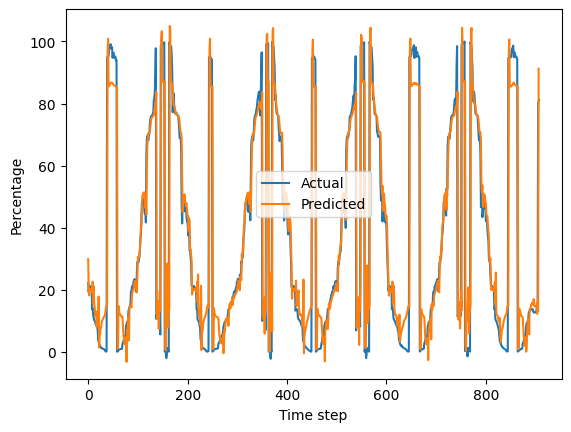

In [73]:
test_predictions = model.predict(test_x)
test_predictions_unscaled = scaler.inverse_transform(np.hstack([test_data[sequence_length + 1:, 0:1], test_predictions]))
test_actual_unscaled = scaler.inverse_transform(test_data[sequence_length:])

plt.plot(test_actual_unscaled[:, 1], label="Actual")
plt.plot(test_predictions_unscaled[:, 1], label="Predicted")
plt.xlabel("Time step")
plt.ylabel("Percentage")
plt.legend()
plt.show()
